In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob
import dask
import os

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

# from dask.distributed import Client, LocalCluster
# from cosima_cookbook import distributed as ccd

In [3]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
# client = Client(n_workers=48)
# client = Client(LocalCluster(n_workers=48, threads_per_worker=1, local_directory=os.environ["PBS_JOBFS"]))
# client
import climtas.nci
climtas.nci.GadiClient()

Client Scheduler: tcp://127.0.0.1:44009 Dashboard: /proxy/8787/status,Cluster Workers: 1 Cores: 1 Memory: 4.29 GB


In [4]:
# session = cc.database.create_session('/g/data/ik11/databases/iaf_jrav140.db')
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [5]:
exptdict = OrderedDict([
#     ('01deg_RYF9091',   {'expt':'01deg_jra55v13_ryf9091','dir':'access-om2-01'}),
    ('01deg_IAF',  {'expt':'01deg_jra55v140_iaf','dir':'access-om2-01'})
                        ])

## Just checking the final data for each expt.

In [7]:
for ekey in exptdict.keys():
    variable = 'temp_global_ave'
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session)
#     print(repr(var['time'].min()) + ' to ' + repr(var['time'].max()))
    start_year = np.int(np.ceil(cftime.date2num(var['time'].min(),'days since 0001-01-01','noleap')/365))
    end_year = np.int(np.ceil(cftime.date2num(var['time'].max(),'days since 0001-01-01','noleap')/365))
    print(expt+' goes from %d to (at least some of) %d'% (start_year, end_year))
    
end_time = '2018-12-31'
print(' Setting end_time to',end_time)

01deg_jra55v140_iaf goes from 1958 to (at least some of) 2018
 Setting end_time to 2018-12-31


## compute_delayed
from Angus: 
https://arccss.slack.com/archives/C6PP0GU9Y/p1595293252452600?thread_ts=1594265206.425100&cid=C6PP0GU9Y

In [8]:
def compute_delayed(ds):
    from itertools import product
    import numpy as np
    slices = []
    for chunks in ds.chunks:
        L = [0] + list(np.cumsum(chunks))
        slices.append([slice(*s) for s in zip(L[:-1], L[1:])])
    indices = list(product(*slices))
    out = xr.zeros_like(ds).load()
    delayed = ds.data.to_delayed()
    for i, d in zip(indices, delayed):
        out.__setitem__(i, d.compute())
    return out

## Scalar diagnostics

In [9]:
def plot_timeseries(variable,end_time):
    plt.figure(figsize=(10,5))
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        var = cc.querying.getvar(expt,variable,session,end_time=end_time)
        var.resample(time='Y').mean().plot(label=ekey)
    plt.title(variable)
    plt.legend()
    return

### Global Average Temperature

CPU times: user 34.9 s, sys: 1.29 s, total: 36.2 s
Wall time: 1min 44s


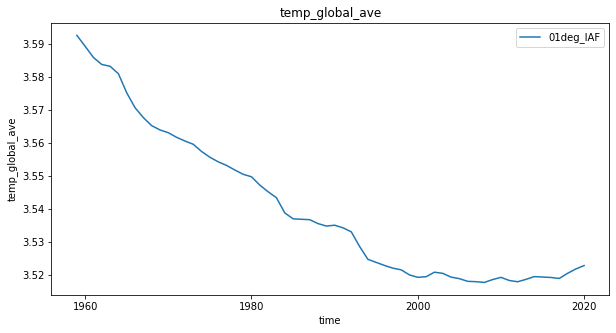

In [10]:
%%time
plot_timeseries('temp_global_ave',end_time)

### Global Average Salinity

CPU times: user 35.5 s, sys: 1.02 s, total: 36.5 s
Wall time: 1min 44s


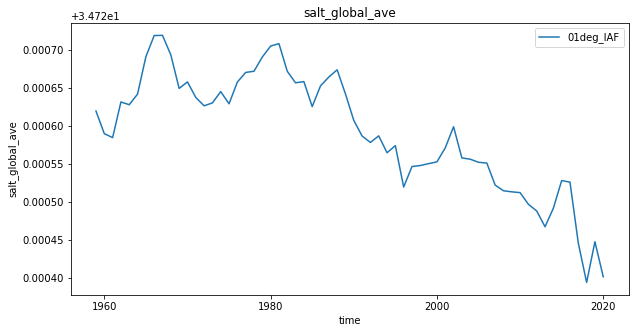

In [11]:
%%time
plot_timeseries('salt_global_ave',end_time)

### Surface Temperature

CPU times: user 36.1 s, sys: 961 ms, total: 37.1 s
Wall time: 1min 45s


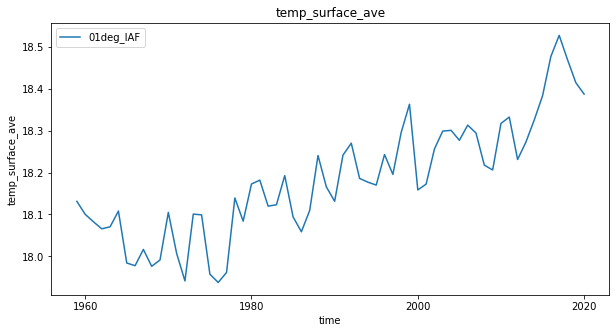

In [12]:
%%time
plot_timeseries('temp_surface_ave',end_time)

### Surface Salinity

CPU times: user 36.5 s, sys: 976 ms, total: 37.5 s
Wall time: 1min 47s


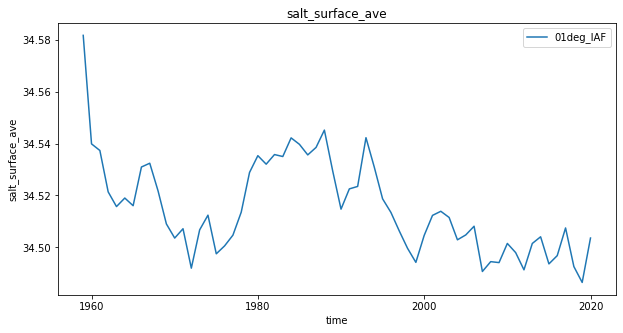

In [13]:
%%time
plot_timeseries('salt_surface_ave',end_time)

### Total Kinetic Energy

CPU times: user 36.6 s, sys: 1 s, total: 37.6 s
Wall time: 1min 47s


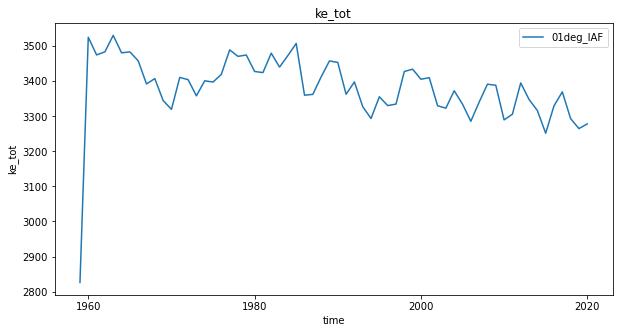

In [14]:
%%time
plot_timeseries('ke_tot',end_time)

## Area-Averaged Tracer Diagnostics

In [15]:
def plot_upper_ocean(variable,end_time):
    plt.figure(figsize=(10,5))
    zlevel = 1000
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        try:
            var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc',end_time=end_time,lock=False)
        except:
            var = cc.querying.getvar(expt,variable,session,ncfile='ocean-3d-'+variable+'-1-monthly-mean-ym%',end_time=end_time,lock=False)
#         varmean = var.sel(st_ocean = slice(0,zlevel)).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean().chunk({'time': 20})
# #         varmeanopt = dask.optimize(varmean.data)[0]
# #         varmeanopt.compute()
#         cvarmean = ccd.compute_by_block(varmean)
#         cvarmean.plot(label=ekey)
# from Angus: https://arccss.slack.com/archives/C6PP0GU9Y/p1595293252452600?thread_ts=1594265206.425100&cid=C6PP0GU9Y
        tmp = compute_delayed(var.sel(st_ocean=slice(0, zlevel)).mean(["st_ocean", "yt_ocean", "xt_ocean"]).chunk({"time": 30}))
        tmp.compute()
        varmean = tmp.resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title('Upper Ocean (< '+str(zlevel)+') '+variable)

### Upper Ocean Temperature/Salinity

01deg_jra55v140_iaf
CPU times: user 2h 7min 44s, sys: 4min 11s, total: 2h 11min 55s
Wall time: 2h 11min 39s


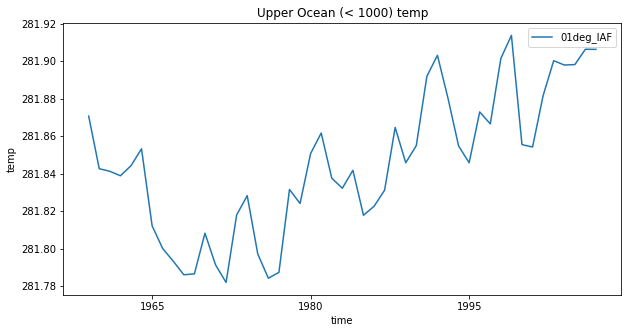

In [9]:
%%time
plot_upper_ocean('temp',end_time)

In [ ]:
%%time
plot_upper_ocean('salt',end_time)

01deg_jra55v140_iaf


### Deep Ocean Temperature/Salinity

In [15]:
def plot_lower_ocean(variable,end_time):
    plt.figure(figsize=(10,5))
    zlevel = 3000
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        try:
            var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc',end_time=end_time,lock=False)
        except:
            var = cc.querying.getvar(expt,variable,session,ncfile='ocean-3d-'+variable+'-1-monthly-mean-ym%',end_time=end_time,lock=False)
#         varmean = var.sel(st_ocean = slice(zlevel,None)).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean()
# from Angus: https://arccss.slack.com/archives/C6PP0GU9Y/p1595293252452600?thread_ts=1594265206.425100&cid=C6PP0GU9Y
        tmp = compute_delayed(var.sel(st_ocean=slice(0, zlevel)).mean(["st_ocean", "yt_ocean", "xt_ocean"]).chunk({"time": 30}))
        tmp.compute()
        varmean = tmp.resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title('Deep Ocean (> '+str(zlevel)+') '+variable)
    

In [ ]:
%%time
plot_lower_ocean('temp',end_time)

In [ ]:
%%time
plot_lower_ocean('salt',end_time)

## Circulation Diagnostics

### Drake Passage Transport

In [ ]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='Y').mean()/1e6/1036
    DP.plot(label=ekey)

plt.legend()
plt.title("ACC Transport")

### AABW overturning circulation @ 55°S

**To Do** - add GM to this.

In [ ]:
%%time
latitude=-55
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho').resample(time='Y').mean()
    psi_aabw_sum.plot(label=ekey)
plt.legend()
plt.title('AABW Cell')

### AMOC Overturning @ 26°N

In [ ]:
%%time
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey)
plt.legend()
plt.title('AMOC Cell')

## Global Overturning Streamfunction

In [ ]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):
    plt.figure(figsize=(12,8))
    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

In [ ]:
psi = cc.querying.getvar('01deg_jra55v140_iaf','ty_trans_rho',session,end_time='2067-01-01')
psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
psi_avg.load()
plot_psi(psi_avg)

In [ ]:
psi = cc.querying.getvar('01deg_jra55v13_ryf9091','ty_trans_rho',session,start_time='2058-01-01', end_time='2067-01-01')
psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
psi_avg.load()
plot_psi(psi_avg)

### Ice Area (in both hemispheres)

In [ ]:
variable='aice_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,start_time='1950-01-01',end_time=end_time,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_area.plot(ax=ax[0],label=ekey)
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_area.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

### Ice volume (in both hemispheres)

In [ ]:
variable='vicen_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,start_time='1950-01-01',end_time=end_time,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    vol = var*area_t
    vol_zonalsum = vol.sum('xt_ocean').sum('nc')
    NH_vol = vol_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_vol.plot(ax=ax[0],label=ekey)
    SH_vol = vol_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_vol.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')